# Flood Events from Copernicus EMS Activation Mapping

## Overview
In this notebook we will:
- Scrape Copernicus EMS Rapid Activations for a flood event (EMSR Codes).
- Retrieve the zip file urls for a given EMSR Code.
- Download and extract zipped vector shapefiles for a given EMSR Code.

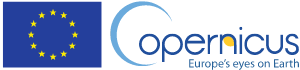

Copernicus EMS provides warnings and risk assessment of floods and other natural disasters through geospatial data derived from satellite imagery. It provides data before, during, and after events in Rapid Mapping format for emergencies and Risk and Recovery format for prevention. In WorldFloods we are primarily interested in the satellite derived imagery with a focus on fluvial, or river, floods.

The Copernicus EMS Activation Mappings for individual events given by unique EMSR codes may be accessed [here]. Linked to each EMSR code per severe event in the Rapid Activations table is the individual webpage for the EMSR code featuring vector zip files from various sources. Each vector zip file may contain multiple products with respect to an event. For this notebook, we will walk through a single EMSR flood event from the alert code, to its associated url


## EMSR 486: Flood in Eastern Sardinia

On 27 November 2020 a deep cyclone brought heavy rainfall along Eastern Sardinia, Italy. During this event rivers flooded impacting nearby cities and roadways. We take this event as an example to show how we retrieve and ingest data as an entry point to the preprocessed data used in the WorldFloods machine learning pipeline.

Below is a picture of Eastern Sardinia during normal non-flood conditions.

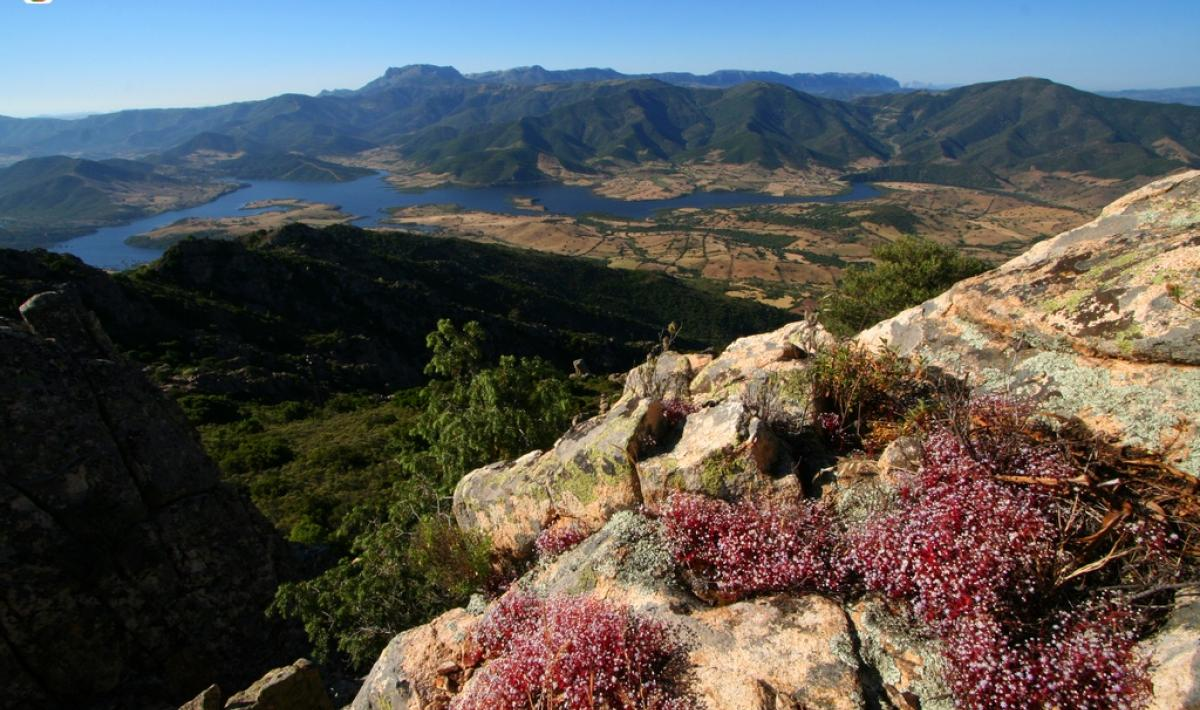

## Retrieve EMSR Flood Event Codes from Copernicus EMS Rapid Mapping

For demonstration purposes, we will fetch the code to get the url of the zipped vector files, then use the urls to download and import EMSR vector zip files to our local machine. In practice, the zipped vector files would be uploaded to the Google Cloud Storage bucket associated with the `ML4floods` project. First, we will need to import modules to assist with the file directory structure or path as well as `src/data/copernicusEMS/activations.py` which houses the functions used to scrape the EMSR data for a given type of hazard and date.

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Geospatial modules and WorldFloods activations mapping module
import geopandas as gpd
from src.data.copernicusEMS import activations

### 1 - Copernicus EMS Rapid Activations Table

We may retrieve a pandas DataFrame format of the [EMS Rapid Activations](https://emergency.copernicus.eu/mapping/list-of-activations-rapid) table using the function <code>table_floods_ems</code> from the activations module in `ml4floods/src/data`. In this function you may specify how far back in time you would like to retrieve flood emergency mappings for. Be careful when choosing dates because _prior to 23 June 2015_ when Sentinel-2 was launched into space.

In [2]:
table_activations_ems = activations.table_floods_ems(event_start_date="2017-01-01")
csv_file = f'{root}/datasets/Copernicus_EMS_raw/table_activations_ems.csv'
table_activations_ems.to_csv(csv_file)
# The first 5 rows of our table
table_activations_ems.head()

,Title,CodeDate,Type,Country
Code,,,,
EMSR502,Flood in Southern Ireland,2021-02-23,Flood,Ireland
EMSR501,Flood in Albania,2021-01-06,Flood,Albania
EMSR498,"Flood in Corrèze department, France",2021-02-02,Flood,France
EMSR497,Flood in Germany,2021-02-01,Flood,Germany
EMSR496,"Flood in Lazio Region, Italy",2021-01-26,Flood,Italy


### 2 - Retrieve the Zip File URLs for a given EMSR Code

The Copernicus EMS Activation Mapping URL location for the November 27th flood event can be fetched using the activation code "EMSR486" and the function <code>fetch_zip_files</code> from <code>activation.py</code> which outputs the url locations as a list of strings. Each of these zip file urls allow us to retrieve the vector shapefiles for different areas of interest within a single activation code.

In [3]:
activation = "EMSR486"

zip_files_activation_url_list = activations.fetch_zip_files(activation)
print(zip_files_activation_url_list)

['https://emergency.copernicus.eu/mapping/download/183885/EMSR486_AOI02_DEL_PRODUCT_r1_RTP01_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183886/EMSR486_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183878/EMSR486_AOI06_GRA_PRODUCT_r1_RTP01_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183879/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector.zip']


### 3 - Download Vector Shapefiles

- Use the list of activation urls to retrieve the vector zipfiles using the function <code>download_vector_cems</code>.
- Unzip the files in a local directory given by <code>unzip_copernicus_ems</code>.

In [4]:
from tqdm import tqdm
from src.data.utils import create_folder

folder_out = f"{root}/datasets/Copernicus_EMS_raw/{activation}"
create_folder(folder_out)

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation_url_list):
    local_zip_file = activations.download_vector_cems(zip_file)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=folder_out)
    unzip_files_activation.append(unzipped_file)

print(unzip_files_activation)

  0%|          | 0/4 [00:00<?, ?it/s]

Folder '/home/satyarth934/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR486' Is Already There.


100%|██████████| 4/4 [00:20<00:00,  5.22s/it]

['/home/satyarth934/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR486/EMSR486_AOI02_DEL_PRODUCT_r1_RTP01_v1_vector', '/home/satyarth934/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR486/EMSR486_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector', '/home/satyarth934/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_RTP01_v1_vector', '/home/satyarth934/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector']


In [5]:
# load additional module
import pickle

with open(f'{root}/datasets/Copernicus_EMS_raw/unzip_files_activation.pickle', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(unzip_files_activation, filehandle)
